# Project 2: &nbsp; _k_-mer Analysis and de Bruijn Graphs

##### Due Friday Apr 29

If two or more people are working on this project enter each person's name here:
* Name:
* Name:
* Name:

### Preparation 

Download the paper by Compeau, Pevzner, and Tesler ("How to apply de Bruijn graphs to genome assembly").

For this project I recommend `scikit-bio` for its Sequence class and an extension to `scipy` called APGL (Another Python Graph Library).  You are welcome to use alternatives, but if you do make sure you tell me which libraries you used and what I might need to do to install them.

In [1]:
from skbio import io, Sequence

In [2]:
from scipy.sparse import lil_matrix
from apgl.graph import SparseGraph, GeneralVertexList
from collections import Counter
import numpy as np

Execute this code cell to import the PyPlot library and tell Jupyter to insert plots in the notebook:

In [3]:
import matplotlib.pyplot as plt
from collections import defaultdict 

% matplotlib inline

Execute these code cells to define the circular "genome" and set of five "reads" shown in Figure 3 of paper:

In [4]:
tiny_genome = Sequence('ATGGCGTGCA')

In [5]:
tiny_reads = [
    Sequence('CGTGCAA'),
    Sequence('TGCAATG'),
    Sequence('ATGGCGT'),
    Sequence('GGCGTGC'),
    Sequence('CAATGGC'),
]

### Part 1: &nbsp; `kmers`

Fill in the body of the function named `kmers` so the function returns all substrings of length _k_ found in a set of sequences.  When it is called we'll pass it a series of Sequence objects and an integer `k`; the function should return a dictionary where keys are _k_-mers found in the sequences and the number of times they were found.

Example:
```
>>> kmers(tiny_reads, 3)
{'AAT': 2,
 'ATG': 3,
 ...
 'TGG': 2}
```

You can write your own loop or use the `scikit-bio` method named `iter_kmers` to make the _k_-mers. 

##### Documentation and Code

Use a sliding window to produce kmers of length k from the list of reads and then use the Counter object to create a dictionary of kmer counts.

In [6]:
def kmers(reads, k):
    
    kmers = []
    
    for i in reads:
        for j in range(len(i)+1-k):
            kmers.append(str(i[j:j+k]))
            
    kmer_count = Counter(kmers)
    
    return kmer_count

##### Autograder Tests 

The notebook grader will run these tests in the order shown.  You are welcome to run these tests, too, but be careful to run them in order (a good set of unit tests should run in any order but some of our tests will use data sets that take several seconds to create so we'll put the "setup" step in a separate cell).

In [7]:
tiny_kmers = kmers(tiny_reads, 3)

In [9]:
assert isinstance(tiny_kmers, dict)

In [10]:
assert len(tiny_kmers) == 10

In [11]:
for kmer in ['ATG', 'TGG', 'CAA']:
    assert kmer in tiny_kmers

In [12]:
assert sum(tiny_kmers.values()) == 25

### Part 2: &nbsp; _k_-mer Spectrum 

Fill in the body of the function named `plot_spectrum` so it draws the _k_-mer spectrum for a set of sequences.  The argument passed to the function will be a dictionary like the one produced by a call to `kmers`, where keys are strings of length _k_ and values are the number of times that string was found.

A spectrum is a plot that has _k_-mer frequency on the _x_ axis.  For any point _x_, the _y_ value is the number of _k_-mers that occur _x_ times.

The easiest way to create a spectrum plot is to generate a histogram using the set of counts in the _k_-mer dictionary.  You can test your function on the _k_-mers of the "tiny reads" data set but the plot will be pretty boring.  5 _k_-mers appear 2 times, and 5 more appear 3 times, so the histogram will have two bars, one at _x_ = 2 and one at _x_ = 3, and both bars will top out at _y_ = 5.  Execute this code cell to see what that might look like:

In [12]:
from IPython.display import Image
Image(url='http://www.cs.uoregon.edu/Classes/16S/cis454/graphics/lectures/spectrum.svg')

##### Documentation and Code

Use histogram function of matplotlib to plot a histogram of kmer frequency

In [8]:
def plot_spectrum(kmers):
    
    frequency = sorted(list(kmers.values()))
    
    plt.hist(frequency, alpha = 1)
    plt.margins(0.1)
    plt.show()

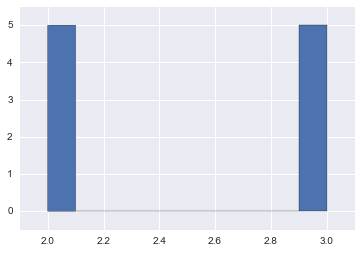

In [10]:
plot_spectrum(tiny_kmers)

### Part 3: &nbsp; Plasmid Reads 

To get a better idea of what the _k_-mer spectrum from a set of Illumina reads looks like download the file named `ColE9-J.fastq` from Canvas.  This file has 2,500 reads, each 150bp, from an _E. coli_ plasmid named ColE9-J. 

For this part of the project you will generate a _k_-mer spectrum plot for this data set, using a value of _k_ that might be used by a genome assembler.

Execute this code cell to make a list containing all 2,500 reads:

In [11]:
plasmid_reads = list(io.read('ColE9-J.fastq', format='fastq', variant='illumina1.8'))

As an additional test of your `plot_spectrum` function I suggest making a plot that uses only a few of the reads (it takes over a minute to count _k_-mers of the full data set on my machine).  This code cell shows how to get 21-mer counts using the first 100 reads:

In [12]:
plasmid_kmers = kmers(plasmid_reads[:100], 21)

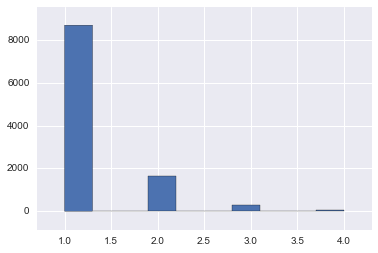

In [13]:
plot_spectrum(plasmid_kmers)

##### Discussion 

When you are confident your _k_-mer counting and plotting functions are working as expected get a count of all 33-mers in the full data set and then make a spectrum plot.

A crucial detail about this data set is that it comes from an experiment with **50x coverage**.  That means each fragment of the genome is expected to occur 50 times in the set of reads.

Use the markdown cell below to describe your plot.  Some things you might include in your discussion:
* can you explain the general shape of the distribution?  
* what is the range of counts along the _x_-axis?
* why are there so many _k_-mers with small counts?
* why is there a maximum in the middle of the range?

**Note:** &nbsp; Your discussion should be more than just a short answer to these 4 questions.  I want you to look at the distribution, consider why it has the shape it does, and what that implies about the data set.


General plot shape is kind of Gaussian, with a massive outlier of small k-mer counts. The high amount of coverage gives the distributation shape, so while none of the kmers had the same coverage as the fragments did, quite a few still had high coverage up to 30. This also explains the x-axis, from 0-30, close to the 50x coverage of the genome fragments. 

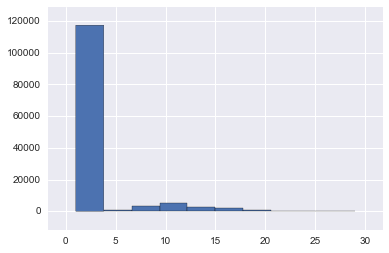

In [14]:
plasmid_kmers_full = kmers(plasmid_reads, 33)

plot_spectrum(plasmid_kmers_full)

### Part 4: &nbsp; de Bruijn Graph

The next part of the project is to write a Python function that creates a de Bruijn graph from a set of reads.  The arguments passed to this function are the same as those passed to `kmers`: a list of reads and a value for _k_.

The function should return two objects:
* a sparse directed graph where the vertices are the (_k_-1)-mers in the reads and the edges are _k_-mers
* a list of all the vertex strings

The easiest way to build a graph for this project is to use the SparseGraph class from the APGL module.  I **_strongly_** recommend you build yourself a "sandbox" to play with this class before working on this project:  create a new notebook, import APGL, create some graphs, learn how to add and remove edges, _etc_.  (Hint: brush up on set operations, as well, and in particular learn how to use "set comprehension" to create a set.)

Here is a suggested outline for your function:
* since we need to know how many nodes are in the graph when the SparseGraph object is created use a "two-pass" algorithm
* first create the list of vertex strings:
    * create an empty set
    * iterate over all the _k_-mers, and add the prefix (first _k_-1 letters) to the set
    * build the vertex list from the set
* you'll want a dictionary that associates a node name with the corresponding node number (since graph nodes in APGL are integers)
* iterate over the _k_-mers again, this time adding edges to the graph:
    * for each _k_-mer, add an edge $ u \rightarrow v $ where $u$ is the node number for the prefix and $v$ is the node number for the suffix (where "prefix" and "suffix" refer the to first _k_-1 and last _k_-1 characters).

Here is the de Bruijn graph for the "tiny" genome:
```
>>> tiny_graph, tiny_vertices = deBruijn(tiny_reads, 3)

>>> tiny_vertices
['CG', 'CA', 'GT', 'AA', 'GG', 'GC', 'AT', 'TG']

>>> tiny_graph.getAllEdges()
array([[0, 2],
       [1, 3],
       [2, 7],
       [3, 6],
       [4, 5],
       [5, 0],
       [5, 1],
       [6, 7],
       [7, 4],
       [7, 5]], dtype=int32)
```
Your vertex list might have a different order, but you should see the same strings.  Verify all the edges from the Compeau paper are in the graph.  For example, in this list there are edges `[7, 4]` and `[7, 5]`.  Looking at the vertex list we can see these are the edges `"TG" ⟼ "GG"` and `"TG" ⟼ "GC"` in the figure.

##### Documentation and Code

use kmers function to create a list of kmers, then using set comprehension find all the prefixes/vertices and then make a list from that. Create a directed SparseGraph object and set vertices to relate each prefix to an int index than can be called later. Then, iterate over kmers again to add the edges to the graph.

In [77]:
def deBruijn(reads, k):
    kmers_count = kmers(reads, k)
    
    vertices_set = {i[:k-1] for i in kmers_count}
    vertices_list = list(vertices_set)
    
    graph = SparseGraph(len(vertices_list), undirected = False)
    graph.setVertices(range(len(vertices_list)), vertices_list)
    
    str_to_int = {graph.getVertex(i): i for i in range(graph.size)}
    
    for i in kmers_count:
        prefix = str_to_int[i[-k+1:]]
        suffix = str_to_int[i[:k-1]]
        graph.addEdge(suffix, prefix)
        
    return graph, vertices_list

In [92]:
tiny_graph.getAllEdges()

array([[0, 6],
       [1, 7],
       [2, 0],
       [2, 3],
       [3, 1],
       [4, 2],
       [5, 2],
       [5, 4],
       [6, 5],
       [7, 5]], dtype=int32)

In [93]:
tiny_graph.getVertices(range(len(tiny_vertices)))

['CG', 'AA', 'GC', 'CA', 'GG', 'TG', 'GT', 'AT']

In [94]:
{tiny_graph.getVertex(i): i for i in range(tiny_graph.size)}

{'AA': 1, 'AT': 7, 'CA': 3, 'CG': 0, 'GC': 2, 'GG': 4, 'GT': 6, 'TG': 5}

##### Autograder Tests 

The notebook grader will run these tests in the order shown.  You are welcome to run these tests, too, but be careful to run them in order.

In [276]:
tiny_graph, tiny_vertices = deBruijn(tiny_reads, 3)

/Users/hrnmy/anaconda3/lib/python3.4/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [152]:
assert len(tiny_vertices) == 8

In [226]:
assert len(tiny_graph.getAllEdges()) == 10

### Part 5: &nbsp; Eulerian Path 

The final part of the project is the function that traverses a de Bruijn graph to produce an assembled sequence.  Fill in the body of the function named `path`.  It takes a graph and its vertex list as arguments and returns a list of nodes on an Eulerian circuit of the graph.

Here is an algorithm that isn't very intuitive but is easy to implement:
1. intitialize two empty lists, `circuit` (which will be the path) and `stack` (as its name implies, it will be a stack of node numbers)
2. pick any node as a starting place; call it the "current node"
3. repeat the following steps:
   - get a list of the successors (outgoing edges) of the current node
   - if the successor list is empty:
      * if the stack is empty the algorithm terminates
      * otherwise add the current node to the circuit
      * pop a node from the stack, and make it the current node
   - otherwise (the successor list is not empty):
      * choose a succcessor node from the list
      * remove the edge from the current node to the sucessor
      * push the current node on the stack
      * make the successor the current node

A detail: when you add a node to the circuit, if you append the node, the final list will be in reverse order; either reverse the list before you return it, or instead of appending, insert the node at the front of the circuit.

You should see something like this when you look for a path in the example graph (`tiny_graph` and `tiny_vertices` are the object returned from the graph building function):
```
>>> path(tiny_graph, tiny_vertices)
[2, 7, 4, 5, 1, 3, 6, 7, 5, 0]
```
(but again your node numbers might be different)

** Challenge:** &nbsp; Can you alter the algorithm so that instead of returning a list of nodes it returns the string of characters in the assembled genome?
```
>>> path(tiny_graph, tiny_vertices)
'GTGGCAATGC'
```

##### Documentation and Code

Using algorithm in notebook, keep while loop while the length of the stack is not equal to the number of edges in the graph, then use SparseGraphs.neighbours to make a list of connecting vertices, and loop through successors if not emtpy and if it is, add current_node to the circuit and set a new current_node

In [283]:
def path(graph, vertices, start = 0):
    
    circuit = []
    stack = []
    
    current_node = start
    
    while len(stack) != graph.getNumEdges():
        successors = list(graph.neighbours(current_node))

        if not successors:
            if not stack: 
                break
            else:
                circuit.insert(0, current_node)
                current_node = stack.pop(0)
        else:
            successor = successors[0]
            graph.removeEdge(current_node, successor)
            stack.append(current_node)
            current_node = successor
    
    string_rep = ''.join([graph.getVertex(i)[:1] for i in circuit])
    
    return string_rep

In [284]:
graph_1, vert_1 = deBruijn(tiny_reads, 3)

/Users/hrnmy/anaconda3/lib/python3.4/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [285]:
test = path(graph_1, vert_1)

In [286]:
len(test)

10

In [216]:
for i in graph_2.getAllEdges():
    print(i)

In [121]:
graph_2.getAllDirEdges()

array([[0, 6],
       [1, 7],
       [2, 0],
       [2, 3],
       [3, 1],
       [4, 2],
       [5, 2],
       [5, 4],
       [6, 5],
       [7, 5]], dtype=int32)

In [127]:
list(graph_2.neighbours(5))

[2, 4]

##### Autograder Tests 

The notebook grader will run these tests in the order shown.  You are welcome to run these tests, too, but be careful to run them in order.

In [277]:
p = path(tiny_graph, tiny_vertices)

In [278]:
assert len(p) == len(tiny_genome)

In [266]:
print(p)

### To Learn More

Here are some ideas for optional projects if you want to keep on exploring genome assembly.

If you want to create your own set of reads (e.g. to increase the coverage, or to make reads for a different genome) download and run Art.  Here is the command I used to make our data set:
```
$ art_illumina -i ColE9-J.fasta -l 150 -ss HS25 -f 50 -o ColE9-J
```
Note: before I ran that command, I copied the first line of the FASTA file and appended it at the end so ART would have a chance to generate "wraparound" reads.

Read about a program named KmerGenie (Chikhi and Medvedev, _Bioinformatics_, 2013) that analyzes a set of reads to estimate the best _k_-mer size to pass to an assember.  What does KmerGenie suggest for our plasmid data?

Draw your de Bruijn graph with `graphviz`.  Figure out how to run `graphviz` from a Jupyter notebook and embed the graphs in the notebook.

If you're really daring, see what kind of de Bruijn graph you can make from the plasmid reads. Filter out the rare _k_-mers (why?) and build a graph from the rest.  Can you make repeated calls to the `path` function to get contigs? 

Copy the plasmid reads to ACISS and try to assemble the genome using Velvet or one of the other genome assembly programs installed there.